In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##XGBoost 분석
앙상블의 부스팅 기법의 한종류.
이전 모델의 오류를 순차적으로 보완해나가는 방식으로 모델을 형성하는데,
더 자세히 알아보면, 이전 모델에서의 실제갑과 예측값의 오차를 훈련데이터에 투입하고 gradient를 이용하여 오류를 보완하는 방식을 사용

In [86]:
csvPath = '/content/drive/MyDrive/train.csv'

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [88]:
df = pd.read_csv(csvPath)
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [89]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [90]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


<ipython-input-91-7631e496f074>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['count'])


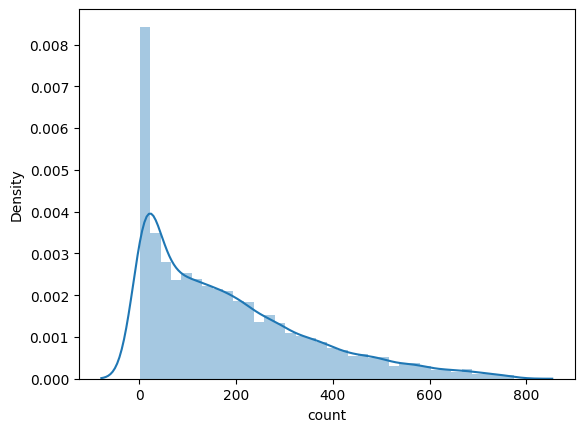

In [91]:
cnt=df['count'].values
q99=np.percentile(cnt,[99])


df=df[df['count']<q99[0]]
sns.distplot(df['count'])
plt.show()


# 그래프는 'count' 열의 데이터 분포를 보여준다.
# 히스토그램은 세로 막대들은 count값들이 특정 구간에 얼마나 많이 분포하는 지를 나타낸다.
# KDE 곡선(커널 밀도 추정)은 데이터의 분포를 매끄럽게 연결한 곡선으로, 데이터의 분포 추세를 부드럽게 보여줌
# 만약 그래프가 한쪽으로 치우쳐 있거나, 특정범위에서 피크가 있다면, 이는 count값들이 특정 구간에 많이 몰려 있음을 의미
# 이상치를 제거한 후에도 여전히 그래프가 비대칭적일 수 있으며, 이는 데이터의 분포 특성(예: 비정규성, 편향)을 반영함

<ipython-input-92-bfb26ee851e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = df['count'].apply(lambda x: np.log(x))
<ipython-input-92-bfb26ee851e4>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['count'])


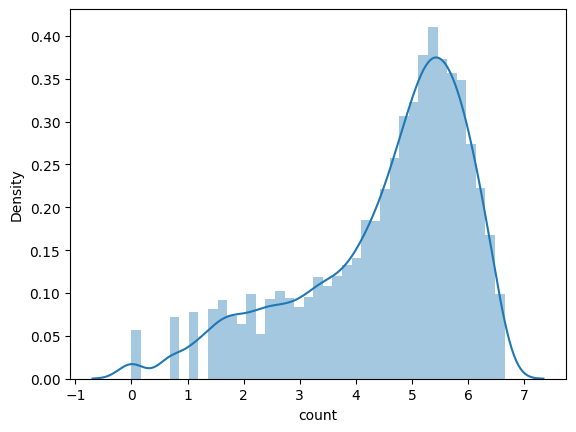

0        2.772589
1        3.688879
2        3.465736
3        2.564949
4        0.000000
           ...   
10881    5.817111
10882    5.484797
10883    5.123964
10884    4.859812
10885    4.477337
Name: count, Length: 10777, dtype: float64


In [92]:
df['count'] = df['count'].apply(lambda x: np.log(x))
sns.distplot(df['count'])
plt.show()
print(df['count'])

# 로그 변환 후 분포: 로그 변환된 데이터의 히스토그램과ㅏ KDE 곡선은 로그 변환이 데이터를 어덯게 변화시켰는지 보여준다.
# 정규화 효과: 로그 변환 후 데이터가 더 정규 분포에 가까워졌다면, 원래의 배대칭적 분포가 완화되었을 가능성이 있다.
# 피크와 분포: 데이터의 분포가 더 균형 잡히거나 정규 분포에 가가워졌다면, 이는 로그 변환이 데이터의 비정상적인 스케일을 효과적으로 조정했음을 의미한다.
## 로그 변환의 장점
# 정규성 향상
# 분산 안정화
# 스케일 조정

<ipython-input-93-36fd57c21edf>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


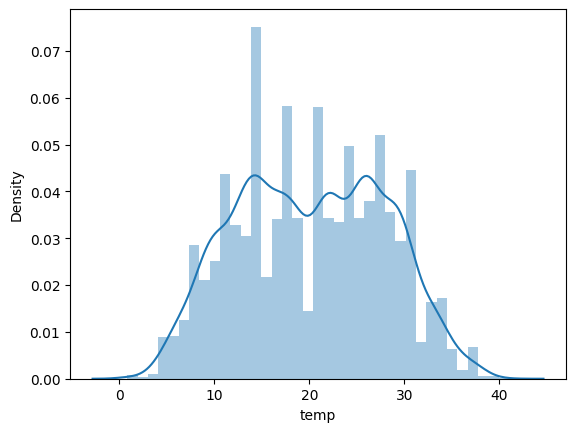

<ipython-input-93-36fd57c21edf>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


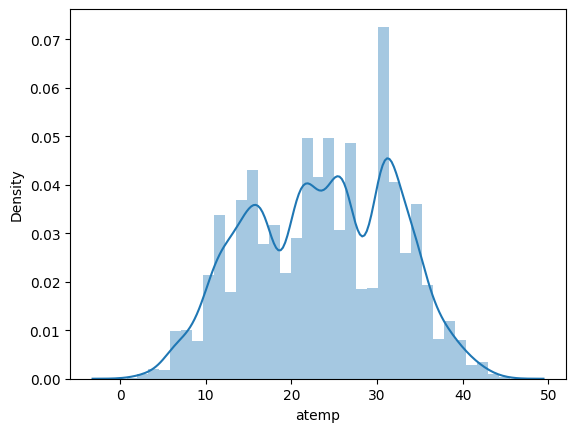

<ipython-input-93-36fd57c21edf>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


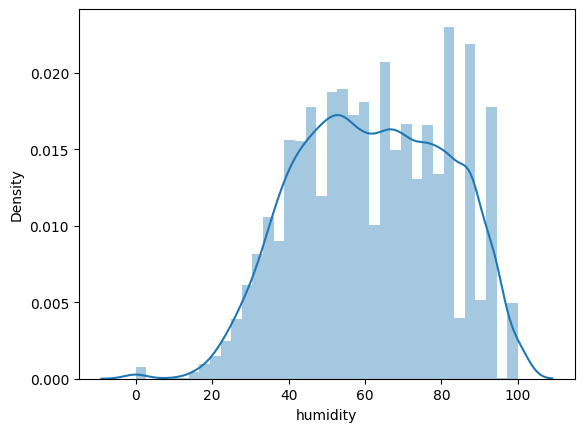

<ipython-input-93-36fd57c21edf>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


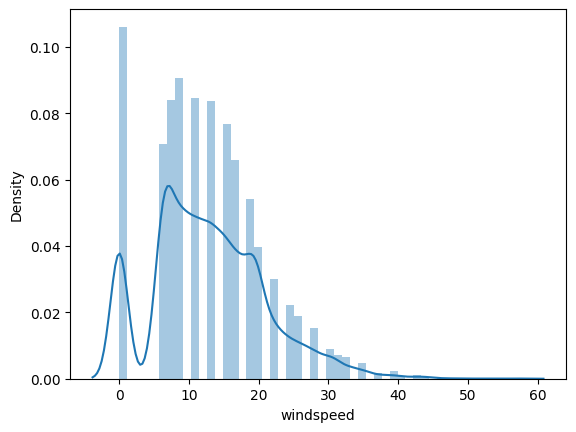

In [93]:
cont_names=['temp','atemp','humidity','windspeed']
for i in cont_names:
  sns.distplot(df[i])
  plt.show()

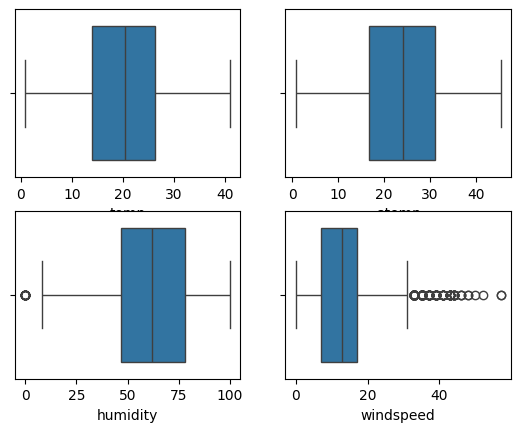

In [94]:
i=0
for name in cont_names:
    i=i+1
    plt.subplot(2,2,i)
    sns.boxplot(x=name,data=df)

plt.show()

# 중앙값 및 범위: 박스플롯을 통해 각 변수의 중앙값과 데이터의 분포 범위를 쉽게 확인할 수 있다. 변수 간의 중앙값 차이나 분포 차이를 비교할 수 있다.
# 이상치: 박스플롯에서 이상치는 수염 끝을 넘어서는 데이터 포인트로 표시됩니다. 이는 특정 변수에서 극단적이 값이 존재함을 나타낸다.
# 변수 분포: 각 변수의 데이터가 어떻게 분포되어 있는지, 데이터의 중앙 집중경향과 변동성을 시각적으로 이해할 수 있다. 데이터가 비대칭적이거나
#           이상치가 많을 경우 박스플롯에서 쉽게 확인할 수 있다.

In [95]:
from datetime import datetime

In [96]:
df2 = df

df2['datetime'] = pd.to_datetime(df2['datetime'])
df2['year'] = df2['datetime'].apply(lambda x: x.year)
df2['month'] = df2['datetime'].apply(lambda x: x.month)
df2['day'] = df2['datetime'].apply(lambda x: x.day)
df2['hour'] = df2['datetime'].apply(lambda x: x.hour)
df2['m-day'] = df2['datetime'].apply(lambda x:str(x.month)+'-'+str(x.day))

df2.head()

<ipython-input-96-9f925472c9f6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['datetime'] = pd.to_datetime(df2['datetime'])
<ipython-input-96-9f925472c9f6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year'] = df2['datetime'].apply(lambda x: x.year)
<ipython-input-96-9f925472c9f6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,m-day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,2.772589,2011,1,1,0,1-1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,3.688879,2011,1,1,1,1-1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,3.465736,2011,1,1,2,1-1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,2.564949,2011,1,1,3,1-1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,0.000000,2011,1,1,4,1-1


이 차트에서, 온도와 시간대(하루 중 시간) 간의 비선형 관계가 계절에 따라 다르게 나타나는 것이 분명합니다. 이를 바탕으로 시간대별로 구간을 나누는 피처 엔지니어링이 필요함


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 80.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 80.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 79.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 80.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 80.3% of the points cannot be plac

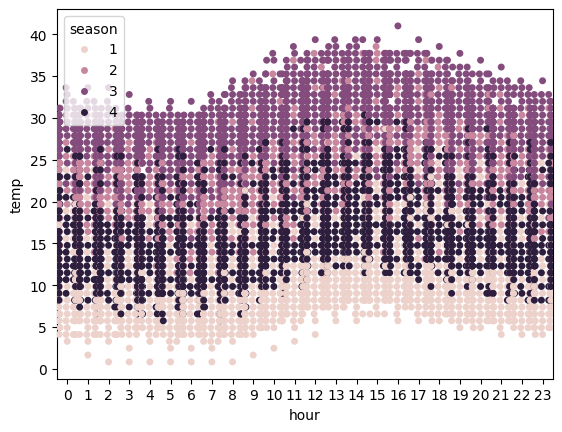

In [97]:
sns.swarmplot(x='hour',y='temp',data=df,hue='season')
plt.show()

# 'swarmplot'은 시간대와 온도 간의 관계를 시각적으로 나타내며, 계절에 따른 분포 차이를 색상으로 구분하여 더 명확하게 볼 수 있게 해준다.
# 그래프를 통해 계절별 온도 변화를 시간대에 따라 분석하고, 데이터의 분포와 이상치를 식별할 수 있다.

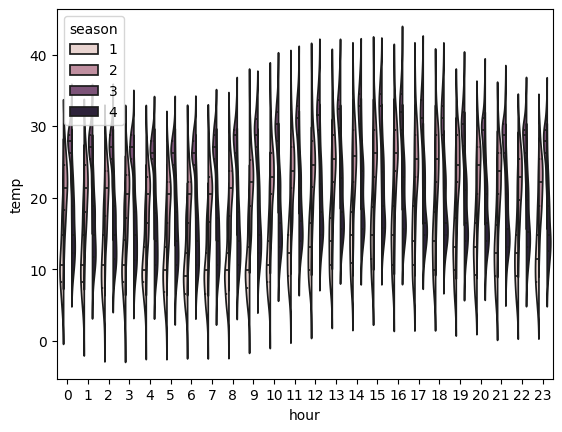

In [98]:
sns.violinplot(x='hour', y='temp', data=df, hue='season', split=True, inner="quartile")
plt.show()

In [99]:
df3 = df.drop(['datetime','temp','windspeed','casual','registered','m-day','day'],axis=1)
df3.head()

,season,holiday,workingday,weather,atemp,humidity,count,year,month,hour
0,1,0,0,1,14.395,81,2.772589,2011,1,0
1,1,0,0,1,13.635,80,3.688879,2011,1,1
2,1,0,0,1,13.635,80,3.465736,2011,1,2
3,1,0,0,1,14.395,75,2.564949,2011,1,3
4,1,0,0,1,14.395,75,0.000000,2011,1,4


In [100]:
weather_df=pd.get_dummies(df2['weather'],prefix='w',drop_first=True)
year_df=pd.get_dummies(df2['year'],prefix='y',drop_first=True)
month_df=pd.get_dummies(df2['month'],prefix='m',drop_first=True)
hour_df=pd.get_dummies(df2['hour'],prefix='h',drop_first=True)
season_df=pd.get_dummies(df2['season'],prefix='s',drop_first=True)

df3 = df3.join(weather_df).astype(int)
df3 = df3.join(year_df).astype(int)
df3 = df3.join(month_df).astype(int)
df3 = df3.join(hour_df).astype(int)
df3 = df3.join(season_df).astype(int)

df3.head()

,season,holiday,workingday,weather,atemp,humidity,count,year,month,hour,...,h_17,h_18,h_19,h_20,h_21,h_22,h_23,s_2,s_3,s_4
0,1,0,0,1,14,81,2,2011,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,13,80,3,2011,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,13,80,3,2011,1,2,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,14,75,2,2011,1,3,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,14,75,0,2011,1,4,...,0,0,0,0,0,0,0,0,0,0


In [101]:
#df3 = df3.astype(int)
#df3.head()

In [102]:
df3.columns

Index(['season', 'holiday', 'workingday', 'weather', 'atemp', 'humidity',
       'count', 'year', 'month', 'hour', 'w_2', 'w_3', 'w_4', 'y_2012', 'm_2',
       'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12',
       'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10',
       'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19',
       'h_20', 'h_21', 'h_22', 'h_23', 's_2', 's_3', 's_4'],
      dtype='object')

In [103]:
x = df3.iloc[:,df3.columns!='count'].values
print(x)

y = df3.iloc[:,6].values
print(y)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [4 0 1 ... 0 0 1]
 [4 0 1 ... 0 0 1]
 [4 0 1 ... 0 0 1]]
[2 3 3 ... 5 4 4]


In [104]:
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [105]:
xgr = xg.XGBRegressor(max_depth=8, min_child_weight=6,gamma=0.4)
xgr.fit(x,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.4, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [106]:
parameters=[{'subsample':[i/10.0 for i in range(6,10)],'colsample_bytree':[i/10.0 for i in range(6,10)]}]

In [107]:
grid_search = GridSearchCV(estimator=xgr, param_grid=parameters, scoring='neg_mean_squared_error',cv=10, n_jobs=-1)
grid_search = grid_search.fit(x,y)

In [108]:
best_accuracy=grid_search.best_score_
best_parameters=grid_search.best_params_
print(best_accuracy)
print(best_parameters)

-0.24440064679724066
{'colsample_bytree': 0.8, 'subsample': 0.9}


In [ ]:
rf=RandomForestRegressor(n_estimators=1000,random_state=0)
rf.fit(x,y)
imp_list=rf.feature_importances_
feats={}

for feature, importance in zip(df3.columns, imp_list):
  feats[feature]=importance

import operator
sorted_x=sorted(feats.items(),key=operator.itemgetter(1),reverse=True)
print(sorted_x)

[('month', 0.6631409852019526), ('atemp', 0.061944794366332656), ('workingday', 0.05680243094408518), ('humidity', 0.034263141283656644), ('year', 0.03251047578104053), ('h_3', 0.015507260381727084), ('count', 0.014909757480077493), ('w_4', 0.014480309915073205), ('h_2', 0.011511123323847877), ('season', 0.010260201174944106), ('h_5', 0.009406123643193378), ('h_4', 0.00924919255403399), ('weather', 0.007410960636987115), ('h_1', 0.005453926072842183), ('h_7', 0.005272650766872654), ('w_2', 0.004835618368076466), ('h_16', 0.004015356698892929), ('h_6', 0.0036265626025388004), ('h_17', 0.003343340692605358), ('m_12', 0.0028607270572770654), ('holiday', 0.0028504900742010405), ('hour', 0.0022213404493740155), ('h_9', 0.0021421125307852155), ('m_9', 0.001286099636644258), ('m_2', 0.0011893903869771361), ('y_2012', 0.001151057429837663), ('h_10', 0.001080539303802131), ('m_3', 0.0010240345418037178), ('m_8', 0.0010192311511938725), ('s_2', 0.000957123752900847), ('m_4', 0.000956681656262657

In [ ]:
xgr = xg.XGBRegressor(max_depth=8, min_child_weight=6, gamma=0.4, colsample_bytree=0.6, subsample=0.6)
xgr.fit(x,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.4, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
df4 = pd.read_csv('/content/drive/MyDrive/test.csv')
df4.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
df4['datetime'] = df4['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

df4['month']=df4['datetime'].apply(lambda x:x.month)
df4['hour']=df4['datetime'].apply(lambda x:x.hour)
df4['day']=df4['datetime'].apply(lambda x:x.day)
df4['year']=df4['datetime'].apply(lambda x:x.year)

df4.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,hour,day,year
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,1,0,20,2011
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,1,20,2011
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,2,20,2011
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,3,20,2011
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,4,20,2011


In [ ]:
df4 = df4.drop(['datetime','temp','windspeed','day'],axis=1)
df4.head()

,season,holiday,workingday,weather,atemp,humidity,month,hour,year
0,1,0,1,1,11.365,56,1,0,2011
1,1,0,1,1,13.635,56,1,1,2011
2,1,0,1,1,13.635,56,1,2,2011
3,1,0,1,1,12.880,56,1,3,2011
4,1,0,1,1,12.880,56,1,4,2011


In [ ]:
weather_df=pd.get_dummies(df2['weather'],prefix='w',drop_first=True)
year_df=pd.get_dummies(df2['year'],prefix='y',drop_first=True)
month_df=pd.get_dummies(df2['month'],prefix='m',drop_first=True)
hour_df=pd.get_dummies(df2['hour'],prefix='h',drop_first=True)
season_df=pd.get_dummies(df2['season'],prefix='s',drop_first=True)

df4 = df4.join(weather_df).astype(int)
df4 = df4.join(year_df).astype(int)
df4 = df4.join(month_df).astype(int)
df4 = df4.join(hour_df).astype(int)
df4 = df4.join(season_df).astype(int)

df4.head()

,season,holiday,workingday,weather,atemp,humidity,month,hour,year,w_2,...,h_17,h_18,h_19,h_20,h_21,h_22,h_23,s_2,s_3,s_4
0,1,0,1,1,11,56,1,0,2011,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,13,56,1,1,2011,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,13,56,1,2,2011,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,12,56,1,3,2011,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,1,12,56,1,4,2011,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
x_test = df4.iloc[:,:].values
x_test.shape

(6493, 50)

In [ ]:
y_output = xgr.predict(x_test)
y_output

array([2.3415704, 1.9400939, 1.846735 , ..., 3.1020422, 4.0861163,
       3.7259047], dtype=float32)

In [ ]:
op=pd.DataFrame({'count':np.exp(y_output)})
op.to_csv('/path/to/directory/output.csv', index=False)

OSError: Cannot save file into a non-existent directory: '/path/to/directory'

In [ ]:
print(op)

In [ ]:
print (np.exp(y_output))